# Deep Learning Project

**Partner: Richard CHEAM, Loïc XU, Janikson GARCIA BRITO	**

# Import libraries

In [ ]:
##### base #####
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
from tqdm import tqdm
##### sklearn #####
from sklearn.model_selection import train_test_split
##### torch ######
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset, Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

# Setup

In [ ]:
torch.cuda.is_available()

True

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


# Load and check MNIST dataset

In [ ]:
# mean and std for MNIST dataset
mean, std = 0.1307, 0.3081

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Load MNIST training and testing dataset
original_train_ds = torchvision.datasets.MNIST(root = 'data/', train = True, transform = transform, download = True)
original_test_ds = torchvision.datasets.MNIST(root = 'data/', train = False, transform = transform, download = True)

print('Train dataset:', len(original_train_ds))
print('Test dataset:', len(original_test_ds))

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.76MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Train dataset: 60000
Test dataset: 10000


In [ ]:
classes = original_train_ds.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
# data[a][b]: a is an image, b is its info where data[a][0]: data, data[a][1]: label
class_count = [original_train_ds[img][1] for img in range(len(original_train_ds))] # iterate through each image
print("Labels count:", dict(Counter(class_count)))

Labels count: {5: 5421, 0: 5923, 4: 5842, 1: 6742, 9: 5949, 2: 5958, 3: 6131, 6: 5918, 7: 6265, 8: 5851}


# 100 labeled MNIST dataset

In [ ]:
def sample_100_digits(data):
    random.seed(42)  # For reproducibility
    labeled_indices = []

    # Loop through digits 0-9 and sample 10 examples per digit
    for digit in range(10):
        label_indices = torch.where(data.targets == digit)[0]
        subset_indices = random.sample(label_indices.tolist(), 10)
        labeled_indices.extend(subset_indices)

    # Create the labeled dataset (100 samples)
    labeled_dataset = Subset(data, labeled_indices)

    # Create the unlabeled dataset by removing the labeled indices
    all_indices = set(range(len(data)))
    unlabeled_indices = list(all_indices - set(labeled_indices))
    unlabeled_dataset = Subset(data, unlabeled_indices)

    return labeled_dataset, unlabeled_dataset

# Plotting the 100 samples
def plot_mnist_samples(dataset):
    fig, axes = plt.subplots(10, 10, figsize=(5, 5))
    axes = axes.flatten()

    for i, (img, label) in enumerate(dataset):
        axes[i].imshow(img[0], cmap='gray')  # Convert the 1-channel tensor to 2D image
        axes[i].axis('off')
        if i % 10 == 0:  # Mark the row with the digit label
            axes[i].set_ylabel(f'Digit {label}', rotation=0, labelpad=10, fontsize=10)

    plt.tight_layout()
    plt.show()

Labels count: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10} 



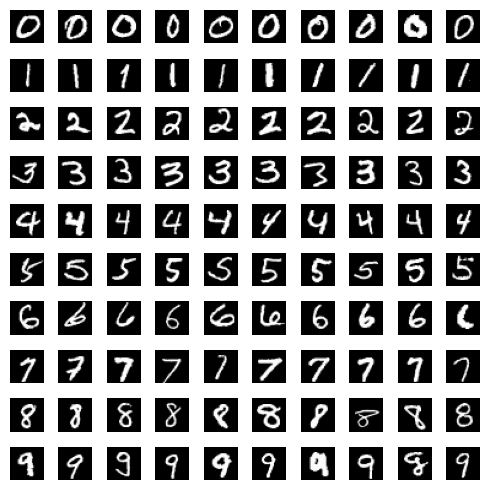

In [ ]:
ds_100_labels, ds_unlabeled = sample_100_digits(original_train_ds)

class_count = [ds_100_labels[img][1] for img in range(len(ds_100_labels))]
print("Labels count:", dict(Counter(class_count)), "\n")

# plot 100 labeled data
plot_mnist_samples(ds_100_labels)

# Data preparation

In [ ]:
# Get labels to stratify the split
labels = []
for i in range(len(ds_100_labels)) :
  _, label = ds_100_labels[i]
  labels.append(label)

# Split indices if the dataset is composed of images
train_idx, val_idx = train_test_split(list(range(len(labels))),
                                              test_size = 0.2,
                                              stratify = labels,
                                              random_state = 42,
                                              shuffle=True)

train_set = torch.utils.data.Subset(ds_100_labels, train_idx)
val_set = torch.utils.data.Subset(ds_100_labels, val_idx)

# data[a][b]: a is an image, b is its info where data[a][0]: data, data[a][1]: label
print("Labels count for training set:", dict(Counter([train_set[img][1] for img in range(len(train_set))])))

Labels count for training set: {9: 8, 5: 8, 6: 8, 2: 8, 3: 8, 0: 8, 4: 8, 7: 8, 1: 8, 8: 8}


In [ ]:
# transformer for data augmentation
def data_transformation(data, transformer_list = [], num_per_img = 10):
  """
  data augmentation applying each transforms for each original image,
  num_per_img is the number of images augmented from each original image for each transform
  """
  torch.manual_seed(42)
  augmented_data = []
  augmented_labels = []
  for i in range(len(data)):
    # Data augmentation
    img, label = data[i]
    augmented_data.append(img)
    augmented_labels.append(label)
    for t in transformer_list:
      # Generate new images from the original image
      for _ in range(num_per_img) :
        random.seed(42)
        new_img = t(img)
        augmented_data.append(new_img)
      # Update new labels
      augmented_labels.extend([label] * (num_per_img))
  augmented_data = torch.stack(augmented_data) # Concatenate a sequence of tensors
  augmented_labels = torch.tensor(augmented_labels)
  return TensorDataset(augmented_data, augmented_labels)

# Visualize the augmented data
def visualize_images(data, title='', rows = 10, cols =10 , fig_size = (5,5)):
  # function to visualize images

  plt.figure(figsize=fig_size)  # Set the figure size to 5x5
  for idx, img in enumerate(data):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img[0].squeeze(), cmap='gray')
    plt.axis('off')
  plt.suptitle(title)
  plt.show()

Augmented data size: 4080 



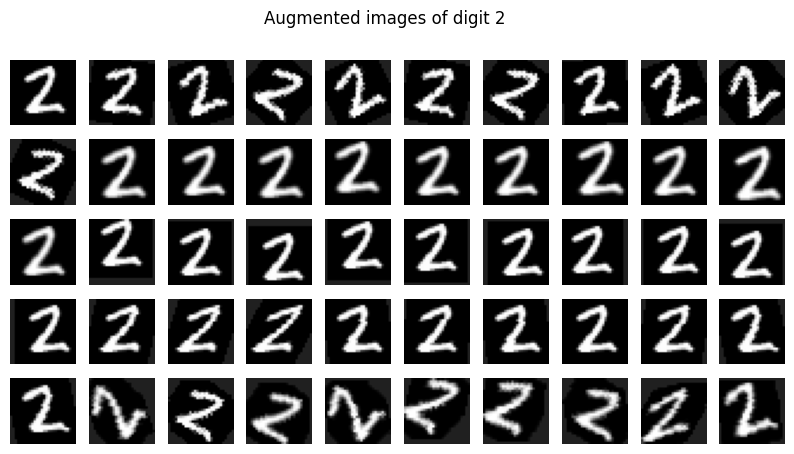

In [ ]:
rotation45 = transforms.Compose([transforms.RandomRotation(45),
                                 transforms.Normalize(mean, std)])

crop_resize = transforms.Compose([transforms.RandomResizedCrop(28, scale=(0.8, 1), ratio = (1,1)),
                                  transforms.Normalize(mean, std)])

translation = transforms.Compose([transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
                                  transforms.Normalize(mean, std)])

shear30 = transforms.Compose([transforms.RandomAffine(0,shear=30),
                            transforms.Normalize(mean, std)])

transform_pipeline = transforms.Compose([transforms.RandomRotation(45),
                                          transforms.RandomResizedCrop(28, scale=(0.8, 1), ratio = (1,1)),
                                          transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
                                          transforms.RandomAffine(degrees = 0, shear = 30),
                                          transforms.Normalize(mean, std)])

transformer_list = [rotation45, crop_resize, translation, shear30, transform_pipeline]

data_aug = data_transformation(train_set, transformer_list, num_per_img = 10)
print("Augmented data size:", len(data_aug), "\n")

# select a digit from augmented data to plot
selected_digit = 2
targets_aug = []
for img in data_aug:
  targets_aug.append(img[1])
indices_label = [i for i in range(len(targets_aug)) if targets_aug[i] == selected_digit]

# visualize selected digit
visualize_images(Subset(data_aug, indices_label[:50]), title=f'Augmented images of digit {selected_digit}' , rows = 5, cols = 10, fig_size = (10,5))

# Model architecture

In [ ]:
def get_memory_params_model(model):
  # Model architecture
  print(model)
  print("Model memory allocation : {:.2e}".format(torch.cuda.memory_reserved(0) - torch.cuda.memory_allocated(0)))

  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in model.parameters())
  print("{} total parameters.".format(total_params))
  total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("{} training parameters.".format(total_trainable_params))

##################### MLP #####################

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.lin1 = nn.Linear(in_features=784, out_features=512)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.lin2 = nn.Linear(in_features=512, out_features=128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.lin3 = nn.Linear(in_features=128, out_features=64)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.lin4 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.lin1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.lin2(x))
        x = self.batchnorm2(x)
        x = F.relu(self.lin3(x))
        x = self.batchnorm3(x)
        x = self.lin4(x)
        return x

##################### CNN #####################

class CNN(nn.Module):
  def __init__(self):
    super().__init__() # always subclass
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding = "same") # conv layer 28x28x32
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(2) # maxpooling 14x14x32

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # first conv layer 12x12x64
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(2) # maxpooling 6x6x64

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # conv lazyer 4x4x128
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(2) # maxpooling 2x2x128

    self.fc1 = nn.Linear(128*2*2, 192) # we have 10 probability classes to predict so 10 output features
    self.batchnorm4 = nn.BatchNorm1d(192)
    self.fc2 = nn.Linear(192, 64)
    self.batchnorm5 = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = self.pool3(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = self.fc3(x)

    return x

print("##################### MLP #####################")

mlp = MLP().to(device)
summary(mlp, input_size=(1, 28, 28))
print("\n\n")
get_memory_params_model(mlp)

print("\n##################### CNN #####################")

cnn = CNN().to(device)
get_memory_params_model(cnn)
print("\n\n")
summary(cnn, input_size=(1, 28, 28))

##################### MLP #####################
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
       BatchNorm1d-2                  [-1, 512]           1,024
            Linear-3                  [-1, 128]          65,664
       BatchNorm1d-4                  [-1, 128]             256
            Linear-5                   [-1, 64]           8,256
       BatchNorm1d-6                   [-1, 64]             128
            Linear-7                   [-1, 10]             650
Total params: 477,898
Trainable params: 477,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.82
Estimated Total Size (MB): 1.84
----------------------------------------------------------------



MLP(
  (lin1): Linear(in_features=784, out_features=512

# Functions for training and evaluation phase

In [ ]:
# Data Loader
def load_data(train, val, test, train_batch, val_batch, test_batch):
  torch.manual_seed(42)
  train_loader = torch.utils.data.DataLoader(train, batch_size=train_batch,
                                          shuffle=True, num_workers=2)
  val_loader = torch.utils.data.DataLoader(val, batch_size=val_batch,
                                         shuffle=False, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch,
                                         shuffle=False, num_workers=2)
  return train_loader, val_loader, test_loader

def get_accuracy(y_true, y_pred):
    return int(np.sum(np.equal(y_true,y_pred))) / y_true.shape[0]

# class to implement Early Stopping
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = float('inf')

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        return True
    return False

# Train function
def train_model(model, epochs, train_loader, val_loader, optimizer_name = 'Adam', patience = 1, early_stopping = True, learning_rate = 0.001, device=None):
  torch.manual_seed(42)
  # Init
  output_fn = torch.nn.Softmax(dim=1) # we instantiate the softmax activation function for the output probabilities
  criterion = nn.CrossEntropyLoss() # we instantiate the loss function
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate) # we instantiate Adam optimizer that takes as inputs the model parameters and learning rate

  loss_valid,acc_valid =[],[]
  loss_train,acc_train =[],[]

  # initialize the early_stopping object
  if early_stopping:
    early_stopper = EarlyStopping(patience=patience)

  for epoch in tqdm(range(epochs)):
    torch.manual_seed(42)
    # Training loop
    model.train() # always specify that the model is in training mode
    running_loss = 0.0 # init loss
    running_acc = 0.

    # Loop over batches returned by the data loader
    for idx, batch in enumerate(train_loader):

      # get the inputs; batch is a tuple of (inputs, labels)
      inputs, labels = batch
      inputs = inputs.to(device) # put the data on the same device as the model
      labels = labels.to(device)

      # put to zero the parameters gradients at each iteration to avoid accumulations
      optimizer.zero_grad()

      # forward pass + backward pass + update the model parameters
      out = model(x=inputs) # get predictions
      loss = criterion(out, labels) # compute loss
      loss.backward() # compute gradients
      optimizer.step() # update model parameters according to these gradients and our optimizer strategy

      # Iteration train metrics
      running_loss += loss.view(1).item()
      t_out = output_fn(out.detach()).cpu().numpy() # compute softmax (previously instantiated) and detach predictions from the model graph
      t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction
      ground_truth = labels.cpu().numpy() # detach the labels from GPU device
      running_acc += get_accuracy(ground_truth, t_out)

    ### Epochs train metrics ###
    acc_train.append(running_acc/len(train_loader))
    loss_train.append(running_loss/len(train_loader))

    # compute loss and accuracy after an epoch on the train and valid set
    model.eval() # put the model in evaluation mode (this prevents the use of dropout layers for instance)

    ### VALIDATION DATA ###
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
      idx = 0
      for batch in val_loader:
        inputs,labels=batch
        inputs=inputs.to(device)
        labels=labels.to(device)
        if idx==0:
          t_out = model(x=inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy() # compute softmax (previously instantiated) and detach predictions from the model graph
          t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction
          ground_truth = labels.cpu().numpy() # detach the labels from GPU device
        else:
          out = model(x=inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item()))
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

      acc_valid.append(get_accuracy(ground_truth,t_out))
      loss_valid.append(np.mean(t_loss))

    print('| Epoch: {}/{} | Train: Loss {:.4f} Accuracy : {:.4f} '\
        '| Val: Loss {:.4f} Accuracy : {:.4f}\n'.format(epoch+1,epochs,loss_train[epoch],acc_train[epoch],loss_valid[epoch],acc_valid[epoch]))

    # early_stopping check if the validation loss has decresed, if yes, it will make a checkpoint of the current model
    if early_stopping:
      stop_bool = early_stopper.early_stop(loss_valid[epoch])
      if stop_bool:
        print("Early stopping")
        break

  # load the last checkpoint with the best model
  #if early_stopping:
    #model.load_state_dict(torch.load('checkpoint.pt'))

  return model, loss_train, loss_valid, acc_train, acc_valid

def plot_accuracy_loss(model_name, loss_train, loss_valid, acc_train, acc_valid) :
  """plot the accuracy and loss functions (for each epoch)
    early_stop_point = True: visualize the early stopping
  """

  fig = plt.figure(figsize = (12, 5))

  # --- Metrics plot
  def plot_metric(model_name, metric_train, metric_valid, metric_name) :
    """plot metrics of both datasets"""
    plt.plot(range(1, len(metric_train) + 1), metric_train, label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
    plt.plot(range(1, len(metric_valid) + 1), metric_valid, label='validation set', marker='o', linestyle='solid',linewidth=1, markersize=6)
    # find position of lowest validation loss
    plt.title(f"{model_name}-model {metric_name}")
    plt.xlabel('#Epochs')
    plt.ylabel(f'{metric_name}')
    plt.legend(bbox_to_anchor=( 1., 1.))

  # Plot loss functions
  ax = fig.add_subplot(121)
  for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
  plot_metric(model_name, loss_train, loss_valid, "Loss")

  # Plot accuracy function
  ax = fig.add_subplot(122)
  for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
  plot_metric(model_name, acc_train, acc_valid, "Accuracy")

def test_model(model, test_loader):
  output_fn = torch.nn.Softmax(dim=1)
  model.eval()
  torch.manual_seed(42)
  with torch.no_grad():
    idx = 0
    for batch in test_loader:
      inputs,labels=batch
      inputs=inputs.to(device)
      labels=labels.to(device)
      if idx==0:
        t_out = model(x=inputs)
        t_out = output_fn(t_out).detach().cpu().numpy()
        t_out=t_out.argmax(axis=1)
        ground_truth = labels.detach().cpu().numpy()
      else:
        out = model(x=inputs)
        t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
        ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
      idx+=1

  return get_accuracy(ground_truth,t_out)

# Training, Validating, Testing

1.   Élément de liste
2.   Élément de liste



In [ ]:
# Load data for train, validate, test
train_ld, val_ld, test_ld = load_data(train_set, val_set, original_test_ds, 20, 20, 20)

  5%|▌         | 1/20 [00:00<00:12,  1.51it/s]

| Epoch: 1/20 | Train: Loss 2.1879 Accuracy : 0.2875 | Val: Loss 2.2136 Accuracy : 0.2500



 10%|█         | 2/20 [00:01<00:08,  2.07it/s]

| Epoch: 2/20 | Train: Loss 0.9274 Accuracy : 0.9250 | Val: Loss 2.0251 Accuracy : 0.4500



 15%|█▌        | 3/20 [00:01<00:06,  2.47it/s]

| Epoch: 3/20 | Train: Loss 0.6240 Accuracy : 1.0000 | Val: Loss 1.8100 Accuracy : 0.6000



 20%|██        | 4/20 [00:01<00:05,  2.74it/s]

| Epoch: 4/20 | Train: Loss 0.4623 Accuracy : 1.0000 | Val: Loss 1.6333 Accuracy : 0.5500



 25%|██▌       | 5/20 [00:01<00:05,  2.84it/s]

| Epoch: 5/20 | Train: Loss 0.3590 Accuracy : 1.0000 | Val: Loss 1.5041 Accuracy : 0.5500



 30%|███       | 6/20 [00:02<00:04,  2.92it/s]

| Epoch: 6/20 | Train: Loss 0.2856 Accuracy : 1.0000 | Val: Loss 1.4121 Accuracy : 0.6000



 35%|███▌      | 7/20 [00:02<00:04,  2.97it/s]

| Epoch: 7/20 | Train: Loss 0.2361 Accuracy : 1.0000 | Val: Loss 1.3458 Accuracy : 0.6000



 40%|████      | 8/20 [00:02<00:04,  2.95it/s]

| Epoch: 8/20 | Train: Loss 0.1990 Accuracy : 1.0000 | Val: Loss 1.2971 Accuracy : 0.6000



 45%|████▌     | 9/20 [00:03<00:03,  3.04it/s]

| Epoch: 9/20 | Train: Loss 0.1697 Accuracy : 1.0000 | Val: Loss 1.2623 Accuracy : 0.6000



 50%|█████     | 10/20 [00:03<00:02,  3.44it/s]

| Epoch: 10/20 | Train: Loss 0.1462 Accuracy : 1.0000 | Val: Loss 1.2368 Accuracy : 0.6000



 55%|█████▌    | 11/20 [00:03<00:02,  3.71it/s]

| Epoch: 11/20 | Train: Loss 0.1276 Accuracy : 1.0000 | Val: Loss 1.2181 Accuracy : 0.6000



 60%|██████    | 12/20 [00:03<00:02,  3.97it/s]

| Epoch: 12/20 | Train: Loss 0.1127 Accuracy : 1.0000 | Val: Loss 1.2043 Accuracy : 0.6000



 65%|██████▌   | 13/20 [00:04<00:01,  4.19it/s]

| Epoch: 13/20 | Train: Loss 0.1005 Accuracy : 1.0000 | Val: Loss 1.1890 Accuracy : 0.6000



 70%|███████   | 14/20 [00:04<00:01,  4.29it/s]

| Epoch: 14/20 | Train: Loss 0.0905 Accuracy : 1.0000 | Val: Loss 1.1752 Accuracy : 0.6000



 75%|███████▌  | 15/20 [00:04<00:01,  4.46it/s]

| Epoch: 15/20 | Train: Loss 0.0821 Accuracy : 1.0000 | Val: Loss 1.1651 Accuracy : 0.6000



 80%|████████  | 16/20 [00:04<00:00,  4.58it/s]

| Epoch: 16/20 | Train: Loss 0.0748 Accuracy : 1.0000 | Val: Loss 1.1558 Accuracy : 0.6000



 85%|████████▌ | 17/20 [00:04<00:00,  4.55it/s]

| Epoch: 17/20 | Train: Loss 0.0686 Accuracy : 1.0000 | Val: Loss 1.1481 Accuracy : 0.6000



 90%|█████████ | 18/20 [00:05<00:00,  4.60it/s]

| Epoch: 18/20 | Train: Loss 0.0632 Accuracy : 1.0000 | Val: Loss 1.1412 Accuracy : 0.6000



 95%|█████████▌| 19/20 [00:05<00:00,  4.58it/s]

| Epoch: 19/20 | Train: Loss 0.0585 Accuracy : 1.0000 | Val: Loss 1.1355 Accuracy : 0.6000



100%|██████████| 20/20 [00:05<00:00,  3.57it/s]

| Epoch: 20/20 | Train: Loss 0.0543 Accuracy : 1.0000 | Val: Loss 1.1304 Accuracy : 0.6000



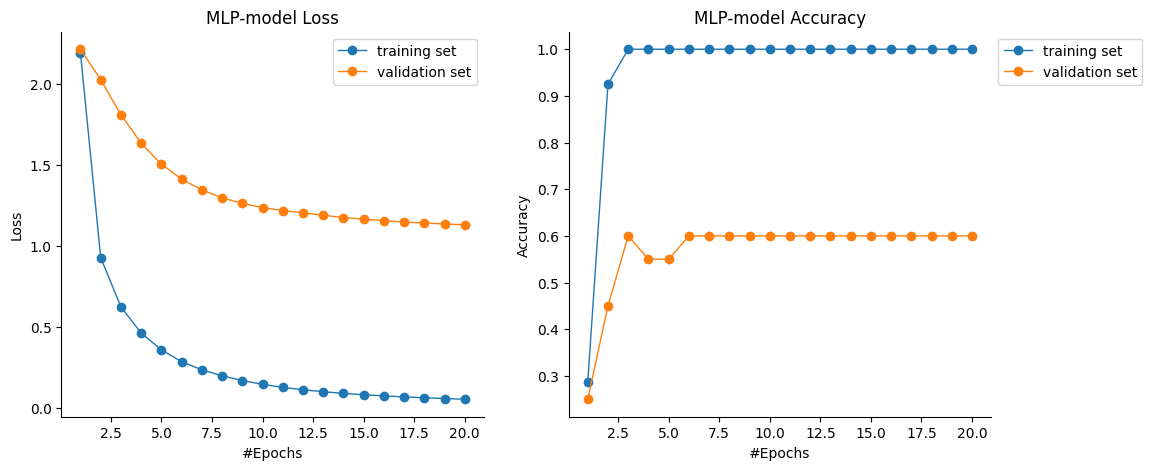

In [ ]:
# train
mlp_trained, loss_train, loss_valid, acc_train, acc_valid = train_model(mlp, 20, train_ld, val_ld, optimizer_name = 'Adam', patience = 10, early_stopping = True, learning_rate = 0.001, device=device)
plot_accuracy_loss('MLP', loss_train, loss_valid, acc_train, acc_valid)

  5%|▌         | 1/20 [00:00<00:07,  2.67it/s]

| Epoch: 1/20 | Train: Loss 2.1382 Accuracy : 0.2500 | Val: Loss 2.2684 Accuracy : 0.1500



 10%|█         | 2/20 [00:00<00:05,  3.45it/s]

| Epoch: 2/20 | Train: Loss 1.2113 Accuracy : 0.8625 | Val: Loss 2.1746 Accuracy : 0.4500



 15%|█▌        | 3/20 [00:00<00:04,  3.78it/s]

| Epoch: 3/20 | Train: Loss 0.9468 Accuracy : 0.9750 | Val: Loss 2.0427 Accuracy : 0.4000



 20%|██        | 4/20 [00:01<00:03,  4.07it/s]

| Epoch: 4/20 | Train: Loss 0.7846 Accuracy : 1.0000 | Val: Loss 1.8879 Accuracy : 0.4500



 25%|██▌       | 5/20 [00:01<00:03,  4.19it/s]

| Epoch: 5/20 | Train: Loss 0.6678 Accuracy : 1.0000 | Val: Loss 1.7333 Accuracy : 0.4500



 30%|███       | 6/20 [00:01<00:03,  4.32it/s]

| Epoch: 6/20 | Train: Loss 0.5773 Accuracy : 1.0000 | Val: Loss 1.5919 Accuracy : 0.5000



 35%|███▌      | 7/20 [00:01<00:03,  4.33it/s]

| Epoch: 7/20 | Train: Loss 0.5031 Accuracy : 1.0000 | Val: Loss 1.4692 Accuracy : 0.6500



 40%|████      | 8/20 [00:01<00:02,  4.34it/s]

| Epoch: 8/20 | Train: Loss 0.4386 Accuracy : 1.0000 | Val: Loss 1.3604 Accuracy : 0.7500



 45%|████▌     | 9/20 [00:02<00:02,  4.34it/s]

| Epoch: 9/20 | Train: Loss 0.3833 Accuracy : 1.0000 | Val: Loss 1.2735 Accuracy : 0.8000



 50%|█████     | 10/20 [00:02<00:02,  4.34it/s]

| Epoch: 10/20 | Train: Loss 0.3365 Accuracy : 1.0000 | Val: Loss 1.2043 Accuracy : 0.8000



 55%|█████▌    | 11/20 [00:02<00:02,  4.41it/s]

| Epoch: 11/20 | Train: Loss 0.2972 Accuracy : 1.0000 | Val: Loss 1.1464 Accuracy : 0.8500



 60%|██████    | 12/20 [00:02<00:01,  4.40it/s]

| Epoch: 12/20 | Train: Loss 0.2641 Accuracy : 1.0000 | Val: Loss 1.0958 Accuracy : 0.8500



 65%|██████▌   | 13/20 [00:03<00:01,  4.44it/s]

| Epoch: 13/20 | Train: Loss 0.2357 Accuracy : 1.0000 | Val: Loss 1.0502 Accuracy : 0.8500



 70%|███████   | 14/20 [00:03<00:01,  4.48it/s]

| Epoch: 14/20 | Train: Loss 0.2112 Accuracy : 1.0000 | Val: Loss 1.0134 Accuracy : 0.8500



 75%|███████▌  | 15/20 [00:03<00:01,  4.45it/s]

| Epoch: 15/20 | Train: Loss 0.1900 Accuracy : 1.0000 | Val: Loss 0.9831 Accuracy : 0.8500



 80%|████████  | 16/20 [00:03<00:00,  4.40it/s]

| Epoch: 16/20 | Train: Loss 0.1718 Accuracy : 1.0000 | Val: Loss 0.9574 Accuracy : 0.8500



 85%|████████▌ | 17/20 [00:03<00:00,  4.40it/s]

| Epoch: 17/20 | Train: Loss 0.1561 Accuracy : 1.0000 | Val: Loss 0.9353 Accuracy : 0.8500



 90%|█████████ | 18/20 [00:04<00:00,  4.42it/s]

| Epoch: 18/20 | Train: Loss 0.1423 Accuracy : 1.0000 | Val: Loss 0.9155 Accuracy : 0.8500



 95%|█████████▌| 19/20 [00:04<00:00,  4.38it/s]

| Epoch: 19/20 | Train: Loss 0.1304 Accuracy : 1.0000 | Val: Loss 0.8984 Accuracy : 0.8500



100%|██████████| 20/20 [00:04<00:00,  4.27it/s]

| Epoch: 20/20 | Train: Loss 0.1199 Accuracy : 1.0000 | Val: Loss 0.8833 Accuracy : 0.8500



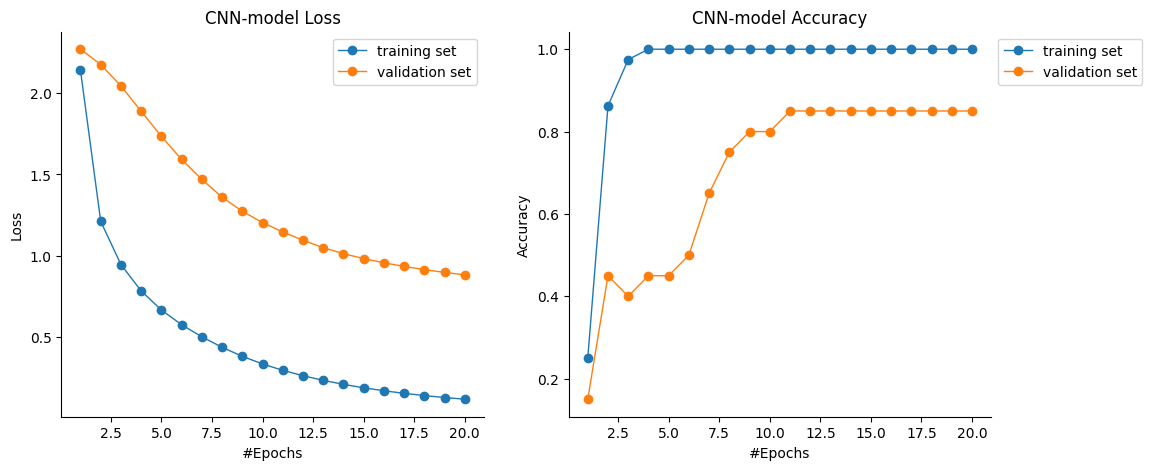

In [ ]:
# train
cnn_trained, loss_train, loss_valid, acc_train, acc_valid = train_model(cnn, 20, train_ld, val_ld, optimizer_name='Adam', early_stopping = False, learning_rate = 0.001, device=device)
plot_accuracy_loss('CNN', loss_train, loss_valid, acc_train, acc_valid)

In [ ]:
# test
print("Accuracy for MLP:", test_model(mlp_trained, test_ld))
print("Accuracy for CNN:", test_model(cnn_trained, test_ld))

Accuracy for MLP: 0.6915
Accuracy for CNN: 0.8369


# SimCLR

In [ ]:
## Load MNIST training and testing dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

original_train_ds = torchvision.datasets.MNIST(root = 'data/', train = True, transform = transform, download = True)
original_test_ds = torchvision.datasets.MNIST(root = 'data/', train = False, transform = transform, download = True)

print('Train dataset:', len(original_train_ds))
print('Test dataset:', len(original_test_ds))

Train dataset: 60000
Test dataset: 10000


In [ ]:
# Data augmentation for SimCLR
transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=28, scale=(0.2, 1.0)),
            transforms.ToTensor(),

    transforms.Normalize((0.1307,), (0.3081,))
])


In [ ]:
# SimCLR dataset
class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.dataset[idx]


        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        img1 = self.transform(img)  # Augmented view 1
        img2 = self.transform(img)  # Augmented view 2
        # img1 and img2 are a positive pair and all the other view are negative pairs for each image

        return img1, img2, label

    def __len__(self):
        return len(self.dataset)


simclr_train_ds = SimCLRDataset(original_train_ds, transform)

In [ ]:
# Basic encoder
# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2))

#     def forward(self, x):
#         x = self.conv(x)
#         x = x.view(x.size(0), -1)
#         return x

In [ ]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(ResidualBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_channels)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         identity = self.shortcut(x)
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.conv2(out)
#         out = self.bn2(out)
#         out += identity # residual connexion
#         out = self.relu(out)
#         return out

# class ResNetEncoder(nn.Module):
#     def __init__(self):
#         super(ResNetEncoder, self).__init__()
#         self.initial = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU()
#         )

#         # 3 residual blocks
#         self.layer1 = ResidualBlock(32, 32, stride=1)
#         self.layer2 = ResidualBlock(32, 64, stride=2)
#         self.layer3 = ResidualBlock(64, 64, stride=2)

#     def forward(self, x):
#         x = self.initial(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = x.view(x.size(0), -1)
#         return x



In [ ]:
class EncoderImproved(nn.Module):
    def __init__(self):
        super(EncoderImproved, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(p=0.3),
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)  # Flatten
        return x

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=4096, output_dim=64):
        super(ProjectionHead, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.mlp(x)


In [ ]:
import torch.nn.functional as F

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        similarity_matrix = torch.mm(z_i, z_j.T)
        labels = torch.arange(z_i.size(0)).to(z_i.device)
        loss = F.cross_entropy(similarity_matrix / self.temperature, labels)
        return loss


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = EncoderImproved().to(device)
projection_head = ProjectionHead().to(device)
criterion = NTXentLoss(temperature=0.5)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(projection_head.parameters()), lr=1e-3)

for epoch in range(15):
    encoder.train()
    projection_head.train()
    total_loss = 0
    for img1, img2, _ in DataLoader(simclr_train_ds, batch_size=128, shuffle=True):
        img1, img2 = img1.to(device), img2.to(device)
        h1, h2 = encoder(img1), encoder(img2)
        z1, z2 = projection_head(h1), projection_head(h2)
        loss = criterion(z1, z2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(simclr_train_ds)}")


Epoch 1, Loss: 0.03057633110284805
Epoch 2, Loss: 0.028999692515532177
Epoch 3, Loss: 0.02839210557937622
Epoch 4, Loss: 0.028001441045602163
Epoch 5, Loss: 0.027795663368701935
Epoch 6, Loss: 0.02765400945742925
Epoch 7, Loss: 0.027489579498767854
Epoch 8, Loss: 0.027380448496341706
Epoch 9, Loss: 0.027290084580580392


KeyboardInterrupt: 

In [ ]:
get_memory_params_model(encoder)

EncoderImproved(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inpla

In [ ]:
get_memory_params_model(projection_head)

ProjectionHead(
  (mlp): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
)
Model memory allocation : 3.85e+08
532672 total parameters.
532672 training parameters.


In [ ]:
class Classifier(nn.Module):
    def __init__(self, encoder):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.mlp = nn.Sequential(
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
            x = self.encoder(x)
            x = self.mlp(x)
            return x


In [ ]:
classifier = Classifier(encoder).to(device)
for param in classifier.encoder.parameters():
    param.requires_grad = False # Freeze the parameters of the encoder that we already trained

In [ ]:
get_memory_params_model(classifier)

Classifier(
  (encoder): EncoderImproved(
    (layer1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, paddin

In [ ]:
# Get labels to stratify the split
labels = []
for i in range(len(ds_100_labels)) :
  _, label = ds_100_labels[i]
  labels.append(label)

# Split indices if the dataset is composed of images
train_idx, val_idx = train_test_split(list(range(len(labels))),
                                              test_size = 0.2,
                                              stratify = labels,
                                              random_state = 42,
                                              shuffle=True)

train_set = torch.utils.data.Subset(ds_100_labels, train_idx)
val_set = torch.utils.data.Subset(ds_100_labels, val_idx)

# data[a][b]: a is an image, b is its info where data[a][0]: data, data[a][1]: label
print("Labels count for training set:", dict(Counter([train_set[img][1] for img in range(len(train_set))])))

In [ ]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True) # replace ds_100_labels by train_set to do validation accuracy
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

import torch.optim as optim

optimizer = optim.Adam(classifier.mlp.parameters(), lr=1e-3)

criterion = torch.nn.CrossEntropyLoss()

def train_classifier(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        # Training accuracy
        train_accuracy = correct / total * 100

        # Validation loop
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                val_outputs = model(val_images)
                val_predictions = torch.argmax(val_outputs, dim=1)
                val_correct += (val_predictions == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_accuracy = val_correct / val_total * 100

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

train_classifier(classifier, train_loader, val_loader, criterion, optimizer, device, epochs=20)


In [ ]:
test_loader = DataLoader(original_test_ds, batch_size=128, shuffle=False)

def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    return accuracy

accuracy = evaluate(classifier, test_loader, device)
print(f"Test Accuracy after training on 100 labels: {accuracy:.2f}%")